In [22]:
# Load packages
import pandas as pd
import numpy as np
import time
import pytz
import matplotlib.pyplot as plt

import lxml.html as lx
import requests
import requests_cache

import newspaper
from newspaper import Article
from newspaper import news_pool

import nltk
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS

#requests_cache.install_cache("mycache")
plt.rcParams["figure.figsize"] = [10, 8]

Useful links for newspaper3k:
https://opendatascience.com/using-the-newspaper-library-to-scrape-news-articles/
https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/

In [3]:
# No need to use this.
# Read the api key. I got this function from Nick's lecture notes from 1/31.
def read_key(keyfile):
    with open(keyfile) as f:
        return f.readline().strip("\n")
    
key = read_key("../keys/googlenews.txt")

In [58]:
# No need to use this.
response = requests.get("https://newsapi.org/v2/everything", params = {
    "q": "camp fire",
    "sortBy": "relevancy",
    "apiKey": key
})

response.raise_for_status()

r = response.json()

{'status': 'ok',
 'totalResults': 2306,
 'articles': [{'source': {'id': 'the-new-york-times',
    'name': 'The New York Times'},
   'author': 'JILL COWAN',
   'title': 'California Today: California Today: Why ‘the Worst of Both Worlds’ Is in the Forecast',
   'description': 'Friday: Californians will most likely face more extreme weather; Pacific Gas & Electric’s role in the Camp Fire; San Diego treats',
   'url': 'https://www.nytimes.com/2019/03/01/us/california-today-extreme-weather-forecast.html',
   'urlToImage': 'https://static01.nyt.com/images/2019/03/01/us/01campfirecatoday/merlin_151063710_b332153e-e314-410c-8eef-5c41339f26bd-facebookJumbo.jpg',
   'publishedAt': '2019-03-01T14:09:58Z',
   'content': 'Im heading to San Diego this weekend, which feels like a real stroke of luck, in light of this weeks recommendation from Tejal Rao, The Timess California restaurant critic. But even if youre far away, take this as an invitation to treat yourself to your favor… [+1197 chars]'},
  {

In [2]:
# Test the newspaper function.
link = "https://www.nytimes.com/2019/02/28/business/energy-environment/pge-camp-fire.html"
#link = 'https://krcrtv.com/news/butte-county/highway-70-to-be-closed-for-emergency-camp-fire-repairs'
#link = "http://krcrtv.com/news/butte-county/hundreds-of-trips-made-per-day-from-paradise-to-oroville-and-wheatland-with-debris"
#link = "https://krcrtv.com/news/camp-fire/camp-fire-debris-removal-could-be-halted-due-to-weather-cal-recycle-says"
article = Article(link)
article.download()
article.parse()
article.text

'Pacific Gas & Electric said Thursday that its equipment had probably caused the Camp Fire, the catastrophic November blaze that destroyed thousands of homes in Paradise, Calif., and killed at least 86 people.\n\nPG&E, which filed for bankruptcy protection in January, said it had recorded a $10.5 billion charge in anticipation of damage claims for that fire, the deadliest in state history. Largely as a result, the company reported a $6.9 billion loss for 2018.\n\nThough the cause of the fire is still under official investigation by California officials, PG&E said it “believes it is probable that its equipment will be determined to be an ignition point of the 2018 Camp Fire.” Attempts to determine the fire’s cause center on the 56-mile Caribou-Palermo electric transmission line.\n\nThe California Department of Forestry and Fire Protection has said the fire started at 6:33 a.m. on Nov. 8 near a tower on that line. PG&E said that its line de-energized at 6:15 a.m., adding that 15 minutes 

In [4]:
# Test memoize_articles = False (don't cache)
article = Article(link, memoize_articles = False)
article.download()
article.parse()
article.text

'Pacific Gas & Electric said Thursday that its equipment had probably caused the Camp Fire, the catastrophic November blaze that destroyed thousands of homes in Paradise, Calif., and killed at least 86 people.\n\nPG&E, which filed for bankruptcy protection in January, said it had recorded a $10.5 billion charge in anticipation of damage claims for that fire, the deadliest in state history. Largely as a result, the company reported a $6.9 billion loss for 2018.\n\nThough the cause of the fire is still under official investigation by California officials, PG&E said it “believes it is probable that its equipment will be determined to be an ignition point of the 2018 Camp Fire.” Attempts to determine the fire’s cause center on the 56-mile Caribou-Palermo electric transmission line.\n\nThe California Department of Forestry and Fire Protection has said the fire started at 6:33 a.m. on Nov. 8 near a tower on that line. PG&E said that its line de-energized at 6:15 a.m., adding that 15 minutes 

In [5]:
#article.summary
#article.keywords
article.publish_date

datetime.datetime(2019, 2, 28, 0, 0)

In [6]:
# Get google news links for each search term
search_term_links = [
    "https://news.google.com/search?q=camp%20fire&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20death%20toll&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20california&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20paradise&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20map&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20news&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20cleanup&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20debris%20removal&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20pg&e&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20investigation&hl=en-US&gl=US&ceid=US%3Aen"
]

In [7]:
# Get article links
def get_links(url):
    """Gets the article links for one Chronicle article list. The parameter "url" is the url to the 
    article list."""
    
    response = requests.get(url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    
    # Get the links that contain the word "article".
    #links = html.xpath("//div/a/@href")
    links = html.xpath("//*[contains(@class, 'NiLAwe y6IFtc R7GTQ keNKEd j7vNaf nID9nc')]/a/@href")

    return links

In [8]:
# Get article links for each search term
l = [get_links(l) for l in search_term_links]

# Unlist the links and get the unique links.
links = [item for sublist in l for item in sublist]
links = np.unique(links)

# Not sure if this line is necessary?
#links = [x.strip() for x in links]

len(links)

676

In [ ]:
# See the links
links

In [9]:
# Extract text and publish data for the urls

# If we don't want to cache:
#config = Config()
#config.memoize_articles = False
#article_1 = Article(url='http://espn/2013/09/...', config)
#https://media.readthedocs.org/pdf/newspaper/latest/newspaper.pdf

def get_article_info(link):
    """Extract the title, text, publish date from a news article. The parameter link is the article link.
    Returns a dictionary of title, text, publish date, and url."""
    
    # Do not get the images.
    article = Article(link, fetch_images = False)
    
    # Not all articles can be downloaded/parsed.
    try:
        article.download()
        article.parse()
        
        title = article.title
        text = article.text # was in a try/except block
        date = article.publish_date
    except:
        # If article can't be parsed, set the variables to None.
        title = None
        text = None
        date = None
    
    url = link
    
    res = {"url": url, 
           "title": title, 
           "text": text,
           "date": date}
    
    #time.sleep(0.05)
    return res

In [10]:
# test it
get_article_info(link)

{'url': 'https://www.nytimes.com/2019/02/28/business/energy-environment/pge-camp-fire.html',
 'title': 'PG&E Says It Probably Caused the Fire That Destroyed Paradise, Calif.',
 'text': 'Pacific Gas & Electric said Thursday that its equipment had probably caused the Camp Fire, the catastrophic November blaze that destroyed thousands of homes in Paradise, Calif., and killed at least 86 people.\n\nPG&E, which filed for bankruptcy protection in January, said it had recorded a $10.5 billion charge in anticipation of damage claims for that fire, the deadliest in state history. Largely as a result, the company reported a $6.9 billion loss for 2018.\n\nThough the cause of the fire is still under official investigation by California officials, PG&E said it “believes it is probable that its equipment will be determined to be an ignition point of the 2018 Camp Fire.” Attempts to determine the fire’s cause center on the 56-mile Caribou-Palermo electric transmission line.\n\nThe California Departme

In [ ]:
# NOTE: extracting article info is extremely slow and results in a huge cache. Not sure if we should still cache?

In [11]:
# Extract article info. Returns a list of dictionaries.
article_list = [get_article_info(x) for x in links]

/Users/christinachang/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [ ]:
# Attempt to make scraping articles faster.


In [12]:
# Convert the article list to a dataframe.
articles = pd.DataFrame(article_list)

# Remove articles where we could not extract the the text.
articles = articles[~articles["text"].isna()]

In [13]:
articles.head()

,date,text,title,url
0,2018-07-30 00:00:00,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,http://fortune.com/2018/07/30/mendocino-comple...
1,2018-11-08 00:00:00,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",http://fortune.com/2018/11/08/california-fires...
2,2018-11-30 00:00:00,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,http://fortune.com/2018/11/30/california-parad...
3,2018-12-07 00:00:00,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,http://fortune.com/2018/12/07/360-degree-video...
4,2019-02-11 00:00:00,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,http://fortune.com/2019/02/11/pge-reshapes-boa...


In [14]:
def tokenize_text(df):
    """Combine the strings in the "text" column of dataframe df into one long string. Then, tokenize the
    string and make all words lowercase."""
    
    # Combine the "text" column into a string.
    doc = ' '.join(df['text'].tolist())

    # Tokenize and make lowercase.
    words = nltk.word_tokenize(doc)
    words = [w.lower() for w in words]
    
    return words

In [15]:
# I took this function from Nick's lecture 2/14. It is for lemmitization.
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

In [16]:
def lemmatize_text(words):
    """Lemmatize words to get the base words. The input 'words' is a list of of words."""
    
    lemmatizer = nltk.WordNetLemmatizer()
    word_tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in word_tags]
    
    return words

In [17]:
def remove_stopwords(words):
    """Remove stopwords from a string."""
    
    stopwords = nltk.corpus.stopwords.words("english")
    words = [w for w in words if w not in stopwords]
    
    return words

In [18]:
# Tokenize, lemmatize, and remove stopwords for the text of all articles.
words = tokenize_text(articles)
words = lemmatize_text(words)
words = remove_stopwords(words)

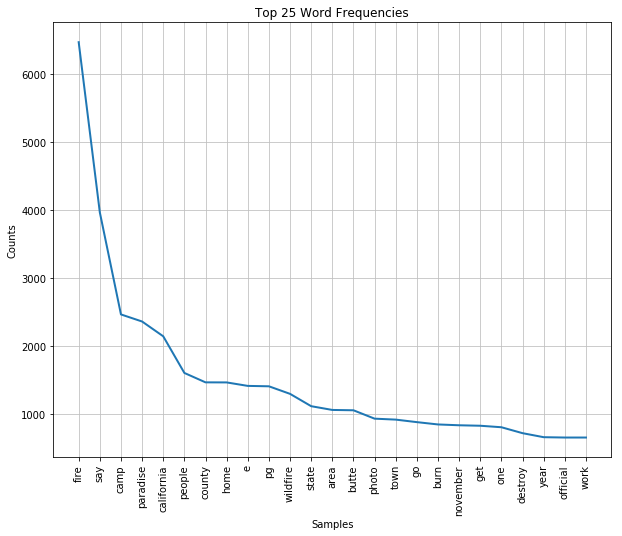

In [21]:
# Create a frequency plot.
fq = nltk.FreqDist(w for w in words if w.isalnum())
fq.plot(25, title = "Top 25 Word Frequencies")

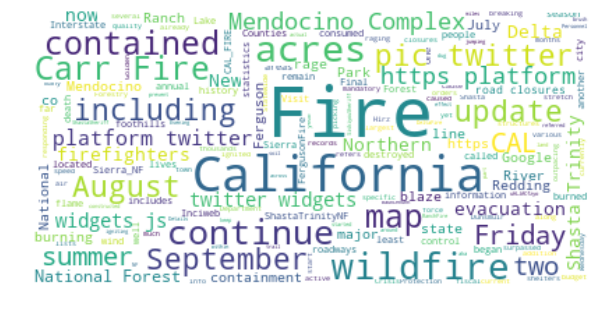

In [35]:
# Try word could with one article
test = articles["text"][0]
wordcloud = WordCloud(max_font_size = 50,
                      #max_words = 100,
                     background_color = "white").generate(test)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

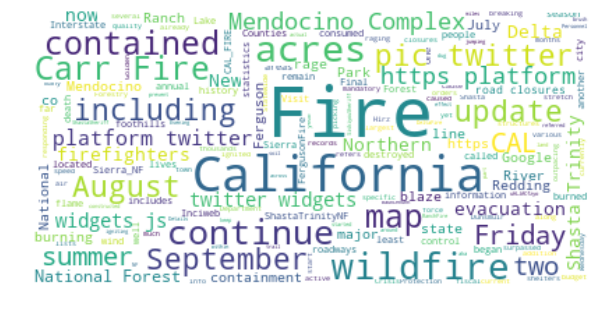

In [40]:
# Word cloud for all articles.
doc = ' '.join(articles['text'].tolist())
WordCloud().generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

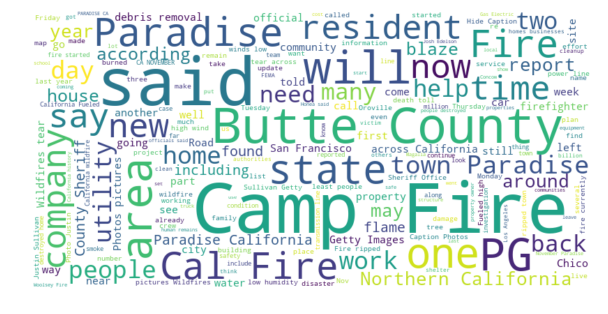

In [42]:
doc = ' '.join(articles['text'].tolist())
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      max_font_size = 100,
                      #max_words = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()